In [24]:
# ============================
# Cell 1: Import & 환경설정
# ============================
import os
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_H, IMG_W = 380, 380  # 이미지 크기 설정

print("="*60)
print("🚀 TTA 추론 환경 설정")
print("="*60)
print(f"🖥️ Device: {DEVICE}")
print(f"📐 Image Size: {IMG_H}x{IMG_W}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*60)

🚀 TTA 추론 환경 설정
🖥️ Device: cuda
📐 Image Size: 380x380
🎮 GPU: NVIDIA GeForce RTX 3090
💾 GPU Memory: 23.69 GB


In [25]:
# ============================
# Cell 2: 테스트 데이터셋 정의
# ============================
class TestDataset(Dataset):
    def __init__(self, img_dir, img_names, img_h, img_w):
        self.img_dir = img_dir
        self.img_names = img_names
        self.img_h = img_h
        self.img_w = img_w
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 이미지 로드
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 원본 이미지(numpy array)와 파일명 반환
        # TTA를 위해 원본 이미지가 필요하므로 변환하지 않음
        return {'image': image, 'img_name': img_name}

In [26]:
# ============================
# Cell 3: 모델 불러오기 함수들
# ============================
import timm
import torch
import torch.nn as nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================
# B4 모델 (당신 - efficientnet_pytorch)
# ============================
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes=17):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

# B4 로드
model_b4 = EfficientNetB4Classifier(num_classes=17).to(DEVICE)
model_b4.load_state_dict(torch.load('best_efficientnet_b4.pth', map_location=DEVICE))
model_b4.eval()
print("✅ EfficientNet-B4 로드 완료")


# ============================
# B5 모델 (상대방 - timm 라이브러리)
# ============================
# ============================
# B5 모델을 timm으로 직접 로드
# ============================
model_b5 = timm.create_model('efficientnet_b5', pretrained=False, num_classes=17)
model_b5.to(DEVICE)
model_b5.load_state_dict(torch.load('best_b5_fold.pth', map_location=DEVICE))
model_b5.eval()
print("✅ EfficientNet-B5 (timm) 로드 완료")


Loaded pretrained weights for efficientnet-b4
✅ EfficientNet-B4 로드 완료
✅ EfficientNet-B5 (timm) 로드 완료


In [27]:
# ============================
# Cell 4: TTA 변환 함수 정의
# ============================
# ============================
# Cell 7: TTA Transforms 정의
# ============================
import albumentations as A
from albumentations.pytorch import ToTensorV2

# B4용 TTA (380x380 또는 224x224)
IMG_SIZE_B4 = 224  # 학습 시 사용한 크기
tta_transforms_b4 = [
    A.Compose([
        A.Resize(IMG_SIZE_B4, IMG_SIZE_B4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE_B4, IMG_SIZE_B4),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE_B4, IMG_SIZE_B4),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
]

# B5용 TTA (456x456 또는 동일 크기)
IMG_SIZE_B5 = 456  # 상대방에게 확인 필요
tta_transforms_b5 = [
    A.Compose([
        A.Resize(IMG_SIZE_B5, IMG_SIZE_B5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE_B5, IMG_SIZE_B5),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    A.Compose([
        A.Resize(IMG_SIZE_B5, IMG_SIZE_B5),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
]

print(f"✅ TTA Transforms 정의 완료")
print(f"  - B4: {len(tta_transforms_b4)}개 변환 (크기: {IMG_SIZE_B4})")
print(f"  - B5: {len(tta_transforms_b5)}개 변환 (크기: {IMG_SIZE_B5})")


✅ TTA Transforms 정의 완료
  - B4: 3개 변환 (크기: 224)
  - B5: 3개 변환 (크기: 456)


In [28]:
# ============================
# Cell 5: TTA 추론 함수
# ============================
def tta_inference(model, image, transforms, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for t in transforms:
            augmented = t(image=image)['image'].unsqueeze(0).to(device)
            output = model(augmented)
            prob = F.softmax(output, dim=1).cpu().numpy()
            preds.append(prob)
    avg_prob = np.mean(preds, axis=0)
    return avg_prob


In [29]:
# ============================
# Cell 6: 모델 로드
# ============================
import timm

print("🔄 모델 로드 중...")

# B4 로드
try:
    model_b4 = EfficientNetB4Classifier(num_classes=17).to(DEVICE)
    model_b4.load_state_dict(torch.load('best_efficientnet_b4.pth', map_location=DEVICE))
    model_b4.eval()
    print("✅ EfficientNet-B4 로드 완료")
except Exception as e:
    print(f"❌ B4 로드 실패: {e}")
    raise

# B5 로드 (timm)
try:
    model_b5 = timm.create_model('efficientnet_b5', pretrained=False, num_classes=17)
    model_b5.to(DEVICE)
    model_b5.load_state_dict(torch.load('best_b5_fold.pth', map_location=DEVICE))  # ✅ 올바른 파일명
    model_b5.eval()
    print("✅ EfficientNet-B5 로드 완료")
except Exception as e:
    print(f"❌ B5 로드 실패: {e}")
    raise

print("🎉 모든 모델 로드 완료!")

🔄 모델 로드 중...
Loaded pretrained weights for efficientnet-b4
✅ EfficientNet-B4 로드 완료
✅ EfficientNet-B5 로드 완료
🎉 모든 모델 로드 완료!


In [30]:
# ============================
# Cell 7: Test 데이터셋 및 DataLoader 준비
# ============================
# TestDataset은 Cell 2에서 이미 정의되어 있습니다 (원본 이미지 반환)
# TTA를 위해 원본 이미지(numpy array)가 필요하므로 Cell 2의 버전을 사용합니다.

def custom_collate_fn(batch):
    """
    딕셔너리 형태의 배치를 처리하는 custom collate function
    원본 이미지(numpy array)를 그대로 유지하기 위해 필요
    """
    images = [item['image'] for item in batch]
    img_names = [item['img_name'] for item in batch]
    return {'image': images, 'img_name': img_names}

test_img_dir = 'test'  # 테스트 이미지 폴더 경로
if not os.path.exists(test_img_dir):
    raise ValueError(f"테스트 이미지 디렉토리가 없습니다: {test_img_dir}")

test_img_names = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.jpg')])
print(f"📁 테스트 이미지 개수: {len(test_img_names)}개")

# Cell 2에서 정의한 TestDataset 사용 (원본 이미지 반환)
test_dataset = TestDataset(test_img_dir, test_img_names, IMG_H, IMG_W)
test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=0,
    collate_fn=custom_collate_fn
)
print("✅ Test DataLoader 준비 완료!")

📁 테스트 이미지 개수: 3140개
✅ Test DataLoader 준비 완료!


In [34]:
# ============================
# Cell 8: 전체 TTA 추론 후 앙상블
# ============================
# 각 모델에 맞는 TTA 변환 사용 (Cell 5에서 정의됨)
# ============================
# Cell 8: TTA 추론 실행
# ============================
print("="*60)
print("🚀 TTA 추론 시작")
print("="*60)
print(f"📊 사용 모델: EfficientNet-B4, EfficientNet-B5")  # ✅ 수정
print(f"⚖️ 앙상블 가중치: B4(0.6), B5(0.4)")  # ✅ 수정
print(f"🔀 TTA 변환:")
print(f"  - EfficientNet-B4: {len(tta_transforms_b4)}개")  # ✅ 크기 제거
print(f"  - EfficientNet-B5: {len(tta_transforms_b5)}개")  # ✅ 변수명 수정
print("="*60 + "\n")

predictions = []
for batch in tqdm(test_loader, desc="TTA 추론 진행"):
    # custom_collate_fn으로 인해 배치는 {'image': [image], 'img_name': [img_name]} 형태
    images = batch['image']  # 리스트
    img_names = batch['img_name']  # 리스트
    
    # batch_size=1이므로 첫 번째 요소 추출
    image = images[0]  # numpy array (H, W, C)
    img_name = img_names[0]  # 파일명 (string)
    
    # 각 모델별 TTA 추론 (각 모델에 맞는 변환 사용)
    prob_b4 = tta_inference(model_b4, image, tta_transforms_b4, DEVICE)
    prob_b5 = tta_inference(model_b5, image, tta_transforms_b5, DEVICE)
    
    # 가중 앙상블 비율: 조정 가능
    ensemble_prob = (prob_b4 * 0.7 + prob_b5 * 0.3)
    
    # argmax로 예측 클래스 추출
    pred_class = ensemble_prob.argmax(axis=1)[0]
    
    predictions.append({'ID': img_name, 'target': int(pred_class)})

print(f"\n✅ 추론 완료: {len(predictions)}개 이미지 처리")




🚀 TTA 추론 시작
📊 사용 모델: EfficientNet-B4, EfficientNet-B5
⚖️ 앙상블 가중치: B4(0.6), B5(0.4)
🔀 TTA 변환:
  - EfficientNet-B4: 3개
  - EfficientNet-B5: 3개



TTA 추론 진행: 100%|██████████| 3140/3140 [05:17<00:00,  9.88it/s]


✅ 추론 완료: 3140개 이미지 처리


In [35]:
# ============================
# Cell 9: 제출 파일 저장
# ============================
# ============================
# Cell 9: 제출 파일 저장
# ============================
if len(predictions) == 0:
    print("❌ 예측 결과가 없습니다. 먼저 Cell 8을 실행하세요.")
else:
    submission = pd.DataFrame(predictions)
    submission_filename = 'submission_b4_b5_ensemble.csv'  # ✅ 파일명 수정
    submission.to_csv(submission_filename, index=False)
    
    print("="*60)
    print("📝 제출 파일 저장 완료")
    print("="*60)
    print(f"✅ 파일명: {submission_filename}")
    print(f"📊 총 예측 개수: {len(submission)}개")
    print(f"\n📈 클래스별 예측 분포:")
    class_counts = submission['target'].value_counts().sort_index()
    for class_id, count in class_counts.items():
        print(f"  클래스 {class_id}: {count}개 ({count/len(submission)*100:.2f}%)")
    print("="*60)

📝 제출 파일 저장 완료
✅ 파일명: submission_b4_b5_ensemble.csv
📊 총 예측 개수: 3140개

📈 클래스별 예측 분포:
  클래스 0: 193개 (6.15%)
  클래스 1: 100개 (3.18%)
  클래스 2: 200개 (6.37%)
  클래스 3: 99개 (3.15%)
  클래스 4: 188개 (5.99%)
  클래스 5: 200개 (6.37%)
  클래스 6: 206개 (6.56%)
  클래스 7: 340개 (10.83%)
  클래스 8: 200개 (6.37%)
  클래스 9: 200개 (6.37%)
  클래스 10: 197개 (6.27%)
  클래스 11: 205개 (6.53%)
  클래스 12: 189개 (6.02%)
  클래스 13: 138개 (4.39%)
  클래스 14: 97개 (3.09%)
  클래스 15: 188개 (5.99%)
  클래스 16: 200개 (6.37%)


📊 예측 결과 분석:
총 예측 개수: 3140

클래스별 예측 분포:
target
0     201
1      90
2     199
3     187
4     191
5     200
6     203
7     207
8     200
9     200
10    205
11    192
12    200
13    151
14    114
15    200
16    200
Name: count, dtype: int64


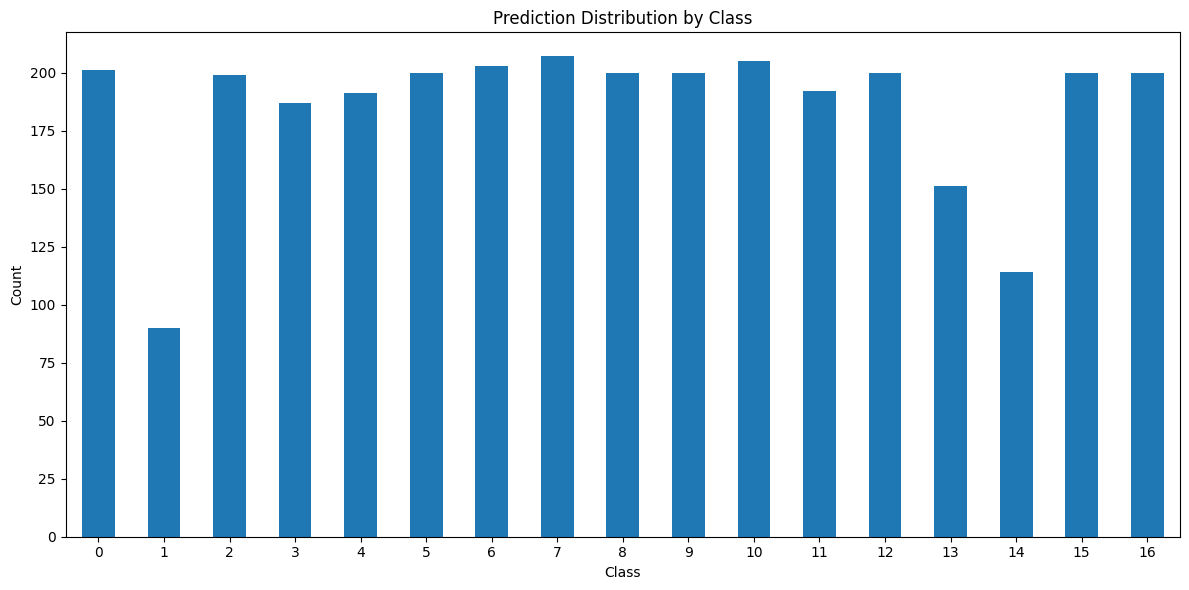

: 

In [ ]:
# ============================
# Cell 10: 예측 결과 분석 (선택사항)
# ============================
if os.path.exists('submission_single_efficientb4_tta.csv'):
    submission_df = pd.read_csv('submission_single_efficientb4_tta.csv')
    
    print("📊 예측 결과 분석:")
    print(f"총 예측 개수: {len(submission_df)}")
    print(f"\n클래스별 예측 분포:")
    print(submission_df['target'].value_counts().sort_index())
    
    # 클래스 분포 시각화
    plt.figure(figsize=(12, 6))
    submission_df['target'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Prediction Distribution by Class')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("제출 파일이 없습니다. 먼저 추론을 실행하세요.")
